<a href="https://colab.research.google.com/github/mking2014/final-4449-king/blob/main/gender_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook Overview

### Purpose
Notebook builds model for predicting a gender given their image.

### Results

Model's 3 performs the best

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

0 = Male <br>
1 = Female

In [7]:
df = pd.read_csv('/content/drive/MyDrive/comp4449_final/data/age_gender.csv')
df = df.drop(columns = ['img_name'])
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (23705, 4)


,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [8]:
# Converting pixels into numpy array
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

# Data Preparation

Data is split into training and test datasets

Text(0, 0.5, 'Count')

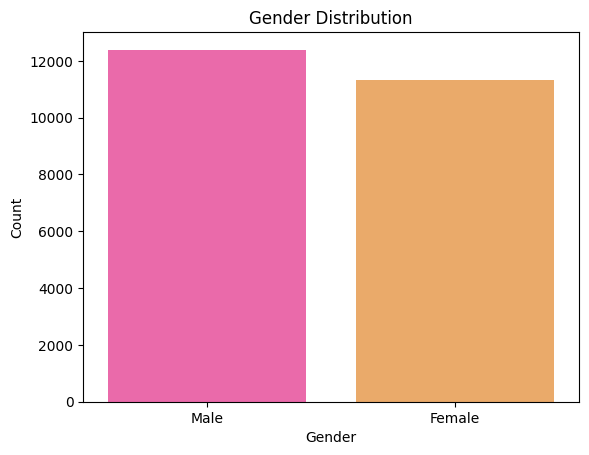

In [9]:
sns.countplot(x="gender", palette='spring', data=df.replace({"gender" : {0 : "Male", 1 : "Female"}}))
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

<Axes: xlabel='age_bin', ylabel='count'>

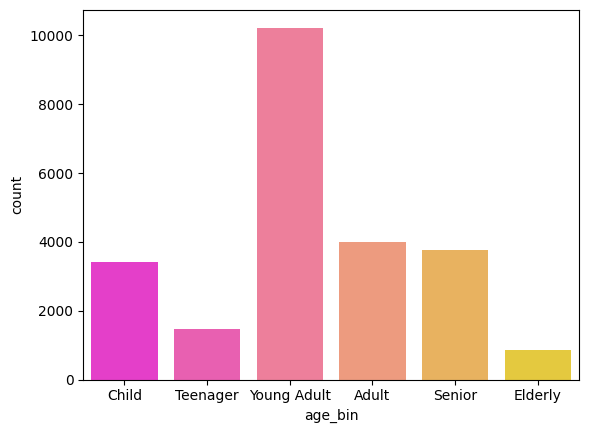

In [11]:
bins = [0, 12, 20, 35, 50, 75, 116]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior', 'Elderly']
df['age_bin'] = pd.cut(x = df['age'], bins = bins, labels = labels, include_lowest = True)
df['age_bin'].value_counts()

sns.countplot(data = df, x = 'age_bin', palette = 'spring')

In [13]:
test, train = train_test_split(df, test_size=0.85, random_state=42)
print(train.shape)
print(test.shape)

(20150, 6)
(3555, 6)


In [14]:
#Reshaping images in training & test datasets

X_train = train['pixels']
# normalizing pixels data
X_train = X_train/255.0

# reshape images
X_train = np.array(X_train.tolist())
X_train = X_train.reshape(-1,48,48, 1)
print(f"Shape of training images: {X_train.shape}")


X_test = test['pixels']
# normalizing pixels data
X_test = X_test/255.0

# reshape images
X_test = np.array(X_test.tolist())
X_test = X_test.reshape(-1,48,48, 1)
print(f"Shape of images: {X_test.shape}")

Shape of training images: (20150, 48, 48, 1)
Shape of images: (3555, 48, 48, 1)


In [16]:
# create y training datasets for age regression model

y_train_gender = train['gender']
print(f"Gender array shape: {(y_train_gender.shape)}")

y_test_gender = test['gender']
print(f"Gender array shape: {(y_test_gender.shape)}")

Gender array shape: (20150,)
Gender array shape: (3555,)


In [17]:
input_shape = (48, 48, 1)

# Model Developmnet

In [18]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, RandomFlip, RandomRotation, RandomContrast, BatchNormalization, RandomZoom
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from math import sqrt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report

### Gender Model (Binary Classification)

Model 0 - Model overfitting
<br>
Model 1
- Accuracy: 0.934
- Precision: 0.9061224489795918
- Recall: 0.9568965517241379
- F1 Score: 0.9308176100628931
- Model overfitting

Model 2
- Accuracy: 0.848
- Precision: 0.875
- Recall: 0.7844827586206896
- F1 Score: 0.8272727272727273
- Added augmentation layers - helped overfitting

Model 3
- Accuracy: 0.892
- Precision: 0.908256880733945
- Recall: 0.853448275862069
- F1 Score: 0.88
- *Overfitting fixed, best model

Model 4 -  Added batch normalization, model severly overfit

Model 5
- Accuracy: 0.878
- Precision: 0.8868778280542986
- Recall: 0.8448275862068966
- F1 Score: 0.8653421633554084
<br>

In [82]:
gender_model = Sequential([

    # augmentation layers
    RandomFlip(mode = 'horizontal', seed = 27, input_shape = (input_shape)),
    RandomFlip(mode = 'vertical', seed = 27),
    RandomRotation(factor = 0.1, fill_mode='nearest', seed = 27),
    RandomContrast(factor = 0.1, seed = 27),

    # convolutional layers
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape = (input_shape)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),

    Dense(1, activation = 'sigmoid')

])
gender_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
gender_model.build(input_shape)
gender_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_10 (RandomFlip  (None, 48, 48, 1)         0         
 )                                                               
                                                                 
 random_flip_11 (RandomFlip  (None, 48, 48, 1)         0         
 )                                                               
                                                                 
 random_rotation_6 (RandomR  (None, 48, 48, 1)         0         
 otation)                                                        
                                                                 
 random_contrast_6 (RandomC  (None, 48, 48, 1)         0         
 ontrast)                                                        
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 64)       

In [83]:
logdir = os.path.join("logs/gender_model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [tensorboard_callback,
             EarlyStopping(patience=4, monitor='val_loss', mode='min'),
             ReduceLROnPlateau(patience=2, verbose=1)
             ]

history = gender_model.fit(X_train, y_train_gender,
                        epochs=100,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_split= 0.2,
                        validation_data=(X_test, y_test_gender))

Epoch 1/100
630/630 [==============================] - 6s 7ms/step - loss: 0.5816 - accuracy: 0.6947 - val_loss: 0.5168 - val_accuracy: 0.7488 - lr: 0.0010
Epoch 2/100
630/630 [==============================] - 4s 6ms/step - loss: 0.5184 - accuracy: 0.7487 - val_loss: 0.4604 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 3/100
630/630 [==============================] - 4s 6ms/step - loss: 0.4837 - accuracy: 0.7721 - val_loss: 0.4418 - val_accuracy: 0.8020 - lr: 0.0010
Epoch 4/100
630/630 [==============================] - 4s 6ms/step - loss: 0.4583 - accuracy: 0.7896 - val_loss: 0.3963 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 5/100
630/630 [==============================] - 4s 6ms/step - loss: 0.4371 - accuracy: 0.8002 - val_loss: 0.4039 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 6/100
630/630 [==============================] - 4s 6ms/step - loss: 0.4254 - accuracy: 0.8048 - val_loss: 0.3894 - val_accuracy: 0.8335 - lr: 0.0010
Epoch 7/100
630/630 [==============================] - 4s 6ms/st

In [88]:
gender_model.save('/content/drive/MyDrive/comp4449_final/models/gender/5')

In [ ]:
# from tensorboard import notebook
# notebook.list()
# # load tensorboard
# notebook.display(port=6006, height=1000)
# %load_ext tensorboard
# %tensorboard --logdir logs

In [35]:
def evaluate_classification_model(labels, preds, cm_labels):

  cm = confusion_matrix(labels, preds)
  sns.heatmap(cm, annot = True, fmt ='.0f', xticklabels=cm_labels, yticklabels=cm_labels)
  plt.ylabel('True Label')
  plt.xlabel('Predictied Label')
  plt.title('Gender Classficiation')
  print(f"Accuracy: {accuracy_score(labels, preds)}")
  print(f"Precision: {precision_score(labels, preds)}")
  print(f"Recall: {recall_score(labels, preds)}")
  print(f"F1 Score: {f1_score(labels, preds)}")
  # print(classification_report(labels, preds, target_names = cm_labels))

  return

def predict_gender(label, img):
  gender_map = {0 : "Male", 1 : "Female"}

  print(f"Actual gender: {gender_map[label]}")

  m_prediction = model.predict(img.reshape(-1,48,48, 1), verbose = 0)
  if m_prediction <0.5:
    print(f'Predicted gender: {gender_map[0]}')
  else:
    print(f'Predicted gender: {gender_map[1]}')

  # print(f"Predicted gender: {gender_map[np.argmax(m_prediction, axis = 1)[0]]}")

  return

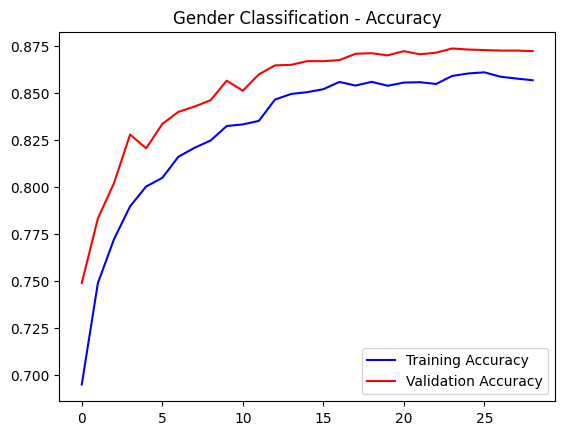

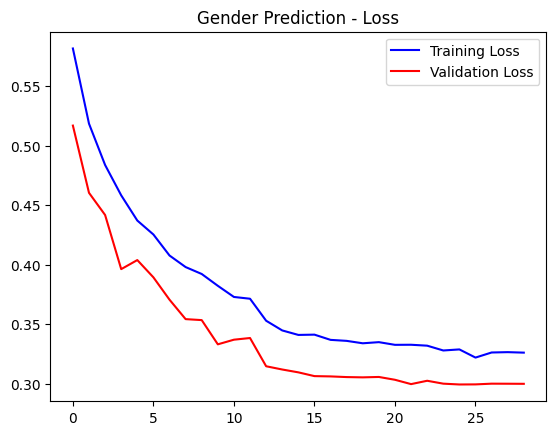

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Classification - Accuracy')
plt.legend()
plt.figure()


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Gender Prediction - Loss')
plt.legend()
plt.show()

In [85]:
valid_score = gender_model.evaluate(X_test, y_test_gender, verbose=1)

112/112 [==============================] - 0s 2ms/step - loss: 0.3000 - accuracy: 0.8723


In [30]:
# Loading best model to display results
model = tf.keras.saving.load_model('/content/drive/MyDrive/comp4449_final/models/gender/3')

In [31]:
y_pred_gender = model.predict(X_test[:500])
pred_classes = [0 if i<0.5 else 1 for i in y_pred_gender]

16/16 [==============================] - 1s 39ms/step


Accuracy: 0.892
Precision: 0.908256880733945
Recall: 0.853448275862069
F1 Score: 0.88


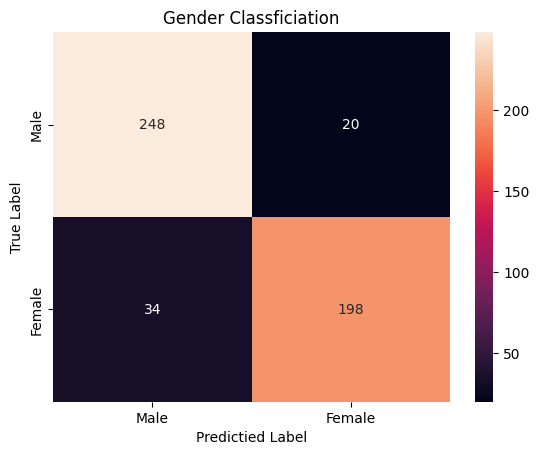

In [32]:
evaluate_classification_model(y_test_gender.values[:500], pred_classes, ['Male', 'Female'])

In [36]:
pred = test.sample()
pred
predict_gender(pred.values[0][2], pred.values[0][3])
# test.iloc[0]

Actual gender: Female
Predicted gender: Female
